In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = '9eda8094b42f4da2b7ab1f1cae4d88fb'

In [4]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

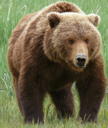

In [6]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [7]:
bear_types = 'grizzly', 'black','teddy'
path = Path('bears')

In [8]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [9]:
fns = get_image_files(path)
fns

(#422) [Path('bears/grizzly/00000054.jpeg'),Path('bears/grizzly/00000012.jpg'),Path('bears/grizzly/00000053.jpg'),Path('bears/grizzly/00000070.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000092.jpg'),Path('bears/grizzly/00000041.png'),Path('bears/grizzly/00000142.jpg'),Path('bears/grizzly/00000078.jpg'),Path('bears/grizzly/00000096.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

In [12]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/conda/lib/python3.7/site-packages/fastai/vision/utils.py
Type:      function


In [13]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),#independent, dependent variables
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

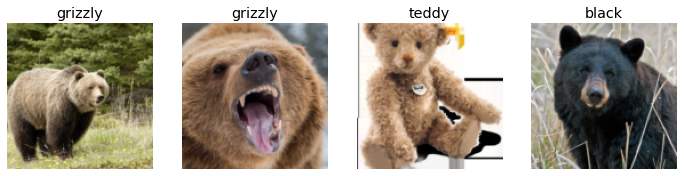

In [14]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

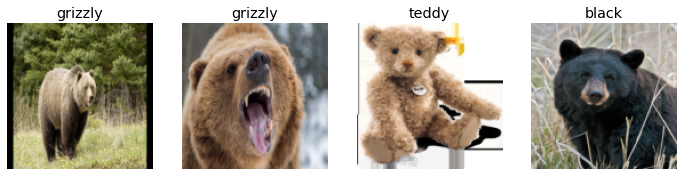

In [15]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

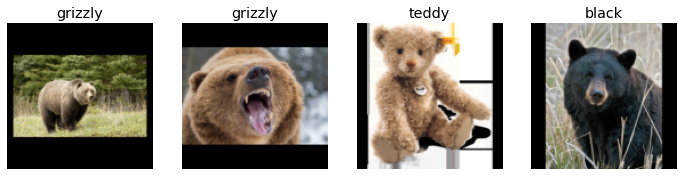

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

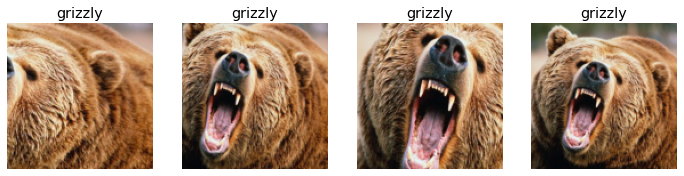

In [17]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

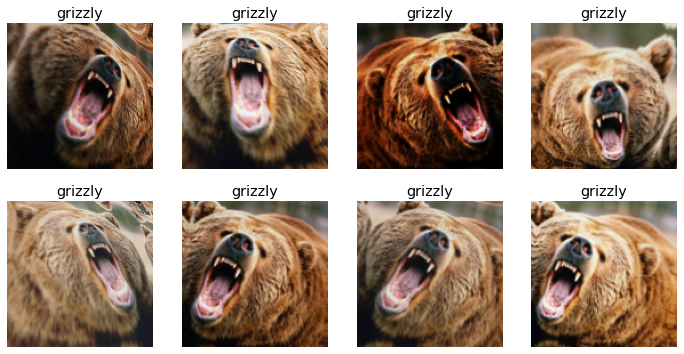

In [18]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.441341,0.136996,0.059524,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.142165,0.019381,0.000000,00:12
1,0.109385,0.006718,0.000000,00:10
2,0.078676,0.005206,0.000000,00:12
3,0.077199,0.002150,0.000000,00:11


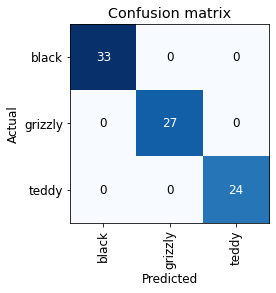

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

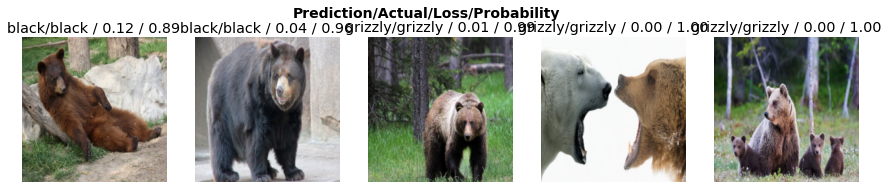

In [22]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.8729e-06, 9.9999e-01, 2.1578e-08]))

In [28]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']